In [127]:
# Needed for the actual stuff
%matplotlib inline 
from glob import glob
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
from data import plot_multiple_images

extension = '.tif'

folder_path = './data/textures/Normalized Brodatz'
imgs = glob(os.path.join(folder_path,'*'+extension))

print(len(imgs))
print(imgs[0])


112
./data/textures/Normalized Brodatz/D19.tif


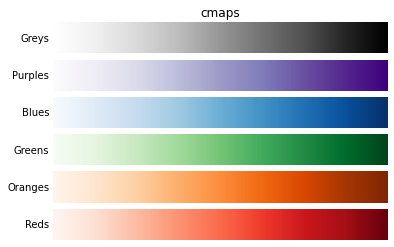

In [128]:
# Demonstrate colour map for the full spectrum of values (all coming from grayscale)
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds']

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

nrows = len(cmaps)
fig, axs = plt.subplots(nrows=nrows)
axs[0].set_title('cmaps')
for ax, cmap in zip (axs, cmaps):
    ax.imshow(gradient, aspect='auto', cmap=cmap)
    ax.text(-.01, .5, cmap, va='center', ha='right', fontsize=10, transform=ax.transAxes)

for ax in axs:
    ax.set_axis_off()

plt.show()


(40, 40)
[(0, 0), (22, 26), (55, 41), (86, 51), (99, 83), (99, 99)]


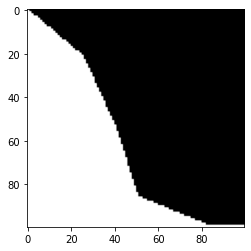

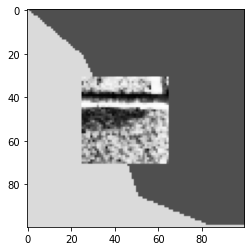

In [129]:
import random
import copy
from PIL import Image

random_image = cv2.imread(random.choice(imgs), cv2.COLOR_BGR2GRAY)
max_x, max_y = random_image.shape

w, h = 40, 40
img_size = (100, 100)

x, y = random.randint(0, max_x-w), random.randint(0, max_y-h)
crop = random_image[y:y+h, x:x+w]  # crops the image into a w,h portion
print(crop.shape)

x, y = 0, 0
# TODO: make it loop over the list itself instead? not neccessary
coords = [(0, 0)]
while x < img_size[0]-1 or y < img_size[1]-1:
    x = min(x + random.randint(10, 40), img_size[0]-1)
    y = min(y + random.randint(10, 40), img_size[1]-1)
    coords.append((x, y))
print(coords)

new_x, new_y = random.randint(
    0, img_size[0]-(w*1.5)), random.randint(0, img_size[1]-(h*1.5))
new_image = np.zeros(img_size, np.uint8)


def bresenhams(array, x1, y1, x2, y2, fill_value=255):
    # from https://github.com/encukou/bresenham/blob/master/bresenham.py
    dx = x2 - x1
    dy = y2 - y1

    xsign = 1 if dx > 0 else -1
    ysign = 1 if dy > 0 else -1

    dx = abs(dx)
    dy = abs(dy)

    if dx > dy:
        xx, xy, yx, yy = xsign, 0, 0, ysign
    else:
        dx, dy = dy, dx
        xx, xy, yx, yy = 0, ysign, xsign, 0

    D = 2*dy - dx
    y = 0

    for x in range(dx + 1):
        a, b = x1 + x*xx + y*yx, y1 + x*xy + y*yy

        array[:a, b] = value
        array[a:, b] = 255-value

        if D >= 0:
            y += 1
            D -= 2*dx
        D += 2*dy


value = random.randint(40, 255)
for c1, c2 in zip(coords, coords[1:]):
    # draw a line between each of the randomly generated coordinates
    bresenhams(new_image, *c1, *c2, fill_value=value)

plt.imshow(Image.fromarray(new_image), cmap='Greys')
plt.show()

# from https://stackoverflow.com/a/50692782


def paste_slices(tup):
    pos, w, max_w = tup
    wall_min = max(pos, 0)
    wall_max = min(pos+w, max_w)
    block_min = -min(pos, 0)
    block_max = max_w-max(pos+w, max_w)
    block_max = block_max if block_max != 0 else None
    return slice(wall_min, wall_max), slice(block_min, block_max)


def paste(wall, block, loc):
    loc_zip = zip(loc, block.shape, wall.shape)
    wall_slices, block_slices = zip(*map(paste_slices, loc_zip))
    wall[wall_slices] = block[block_slices]


show = new_image.copy()
# put the crop into the image, TODO: do this after drawing the line?
paste(show, crop, (new_x, new_y))

# TODO: combine things to cmap on different layer images??
# TODO: add the constant +40 or a -40 to the ligher / darker sides of the pasted texture? and max/min it obv

plt.imshow(Image.fromarray(show), cmap='Greys')


branch1 193 [ 62 193]
6182 3818


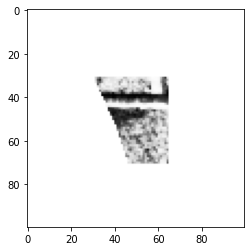

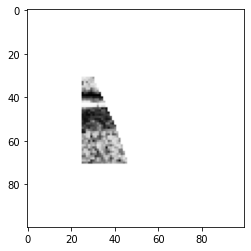

In [130]:
# blanks with texture in correct place
base_textureA = np.zeros(img_size, np.uint8)
paste(base_textureA, crop, (new_x, new_y))
base_textureB = np.zeros(img_size, np.uint8)
paste(base_textureB, crop, (new_x, new_y))

if value > 255//2:
    print(f'branch1 {value} {np.unique(new_image)}')
    a = np.transpose(np.nonzero(new_image==value))
    b = np.transpose(np.nonzero(new_image<value))
    print(f'{len(a)} {len(b)}')

    for coord in b:
        x,y = coord
        base_textureA[x][y] = 0

    for coord in a:
        x,y = coord
        base_textureB[x][y] = 0
else:
    print(f'branch2 {value} {np.unique(new_image)}')
    a = np.transpose(np.nonzero(new_image==value))
    b = np.transpose(np.nonzero(new_image>value))
    print(f'{len(a)} {len(b)}')

    for coord in b:
        x,y = coord
        base_textureA[x][y] = 0

    for coord in a:
        x,y = coord
        base_textureB[x][y] = 0

plt.imshow(Image.fromarray(base_textureA), cmap='Greys')
plt.show()
plt.imshow(Image.fromarray(base_textureB), cmap='Greys')
plt.show()
# plt.imshow(Image.fromarray(new_imageA), cmap='Greys')
# plt.show()
# plt.imshow(Image.fromarray(new_imageB), cmap='Greys')
# plt.show()


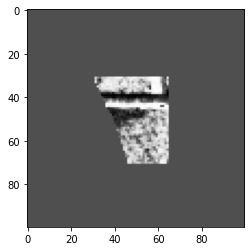

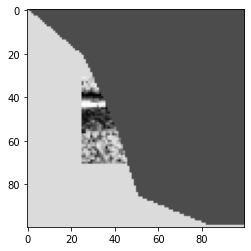

In [131]:
# now combine each texture into it's half, apply a cmap to it

# blanks, with only the portion of left/right half
new_imageA, new_imageB = new_image.copy(), new_image.copy()
new_imageA[new_imageA <= value] = value # set to 0 to see the actual line
new_imageB[new_imageB > value] = 255-value # set to 0 to see the actual line

# get coords from each texture, place the values of those textures into their new_image
textureCoordsA = np.transpose(np.nonzero(base_textureA>0))
textureCoordsB = np.transpose(np.nonzero(base_textureB>0))

# texture_change = random.randint(10,20)
texture_change = 0
for coord in textureCoordsA:
    x,y = coord
    new_imageA[x][y] = min(base_textureA[x][y]+texture_change,255)

for coord in textureCoordsB:
    x,y = coord
    new_imageB[x][y] = min(base_textureB[x][y]+texture_change, 255)

plt.imshow(Image.fromarray(new_imageA), cmap='Greys')
plt.show()
plt.imshow(Image.fromarray(new_imageB), cmap='Greys')
plt.show()

2
100


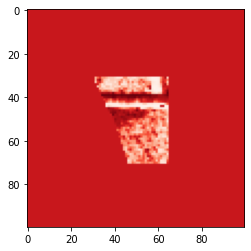

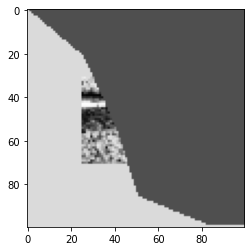

In [132]:
from matplotlib import cm
# and then colour

print(len(new_imageA.shape))
print(len(new_imageA))

if len(new_imageA.shape) < 3:
    a_cmap, b_cmap = np.random.choice(cmaps, 2, replace=False)

    a_cmap_cm = cm.get_cmap(a_cmap)
    new_imageA = a_cmap_cm(new_imageA)

    b_cmap_cm = cm.get_cmap(b_cmap)
    new_imageB = b_cmap_cm(new_imageB)

plt.imshow(new_imageA)
plt.show()
plt.imshow(new_imageB)
plt.show()

Reds Greys


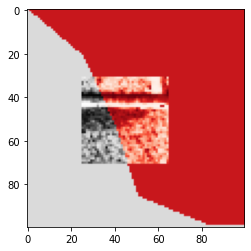

In [133]:
# and combine all together

for coord in b:
    x,y = coord
    new_imageA[x][y] = new_imageB[x][y]
plt.imshow(new_imageA)
print(f'{a_cmap} {b_cmap}')

In [146]:
from matplotlib import image

image.imsave('test.png', new_imageA)